---
title: "regression with CART"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In the previous classification example, we saw how to put each animal into a category (koala, fox, bonobo) based on its features (height and weight). If you haven't read it yet, [go back to the classification example](decision_trees/CART_classification.ipynb).

In regression, instead of putting things into categories, we predict a continuous value. Building on the previous example, let's say we want to predict the age of an animal based on its height and weight.

In [23]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor, plot_tree

Again, we are using the famous Iris dataset structure:

* sepal length (cm) $\rightarrow$ height
* sepal width (cm) $\rightarrow$ weight
* petal length (cm) $\rightarrow$ age

In [40]:
#| code-summary: "load iris dataset and prepare data"
iris = load_iris()
X = iris.data[:, [0, 1]]
y = iris.data[:,[2]].flatten()
iris.feature_names = ['height', 'weight', 'age']

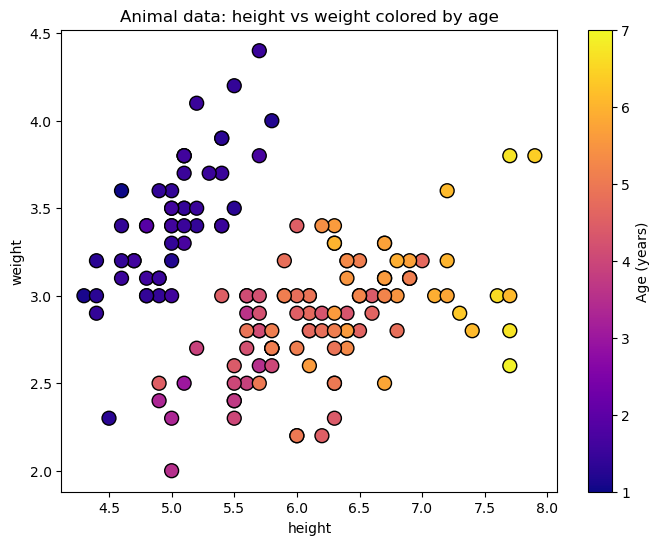

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', edgecolor='k', s=100, vmin=1, vmax=7)
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set(xlabel='height',
       ylabel='weight',
       title="Animal data: height vs weight colored by age")
fig.colorbar(scatter, label='Age (years)')

## the split

We will follow a similar procedure to split the data along the features, but this time our target variable is continuous (age) instead of categorical (animal type).
In classification we wanted to have leaves as pure as possible, and we quantified that either with Gini impurity or entropy.
In regression, we want to minimize the variance of the target variable within each leaf.
In our example, this means that we want to split the data in a way that the ages of the animals in each leaf are as similar as possible.

The cost function we will use to evaluate the quality of a split is the Weighted Mean Squared Error (MSE):

$$
J(j,x) = \frac{N_\text{left}}{N_\text{total}} \cdot \text{MSE}_\text{left} + \frac{N_\text{right}}{N_\text{total}} \cdot \text{MSE}_\text{right},
$$
where $N_\text{left}$ and $N_\text{right}$ are the number of samples in the left and right child nodes, respectively, and $N_\text{total}$ is the total number of samples in the parent node. $\text{MSE}_\text{left}$ and $\text{MSE}_\text{right}$ are the mean squared errors of the target variable in the left and right child nodes:

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \bar{y})^2,
$$
where $y_i$ are the target values in the node, $\bar{y}$ is the mean target value in the node, and $N$ is the number of samples in the node.

The cost function is weighted by the number of samples in each child node to account for the fact that larger nodes have a greater impact on the overall variance.

So how do we know which split is the best? We will evaluate all possible split thresholds $s$ along all features $j$ and choose the one that minimizes the Weighted MSE.
In a mathematical language:

$$
(j^*, s^*) = \arg\min_{j,s} J(j,s).
$$

## sklearn tree DecisionTreeRegressor

We will use the `DecisionTreeRegressor` class from `sklearn.tree` to build our regression tree.

In [42]:
regressior = DecisionTreeRegressor(max_depth=3)
regressior.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [65]:
# Helper function to plot decision boundaries
def plot_decision_boundaries(ax, model, X, y, title):
    """
    Plots the decision boundaries for a given classifier.
    """
    # Define a mesh grid to color the background based on predictions
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict the class for each point in the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the colored regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='plasma', vmin=1, vmax=7)

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])
    ax.set_xticks(())
    ax.set_yticks(())

from mpl_toolkits.mplot3d import Axes3D

# Helper function to plot decision boundaries
def plot_decision_boundaries_3d(ax, model, X, y, title):
    # Define a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict the values for each point in the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the surface
    surf = ax.plot_surface(xx, yy, Z, alpha=0.5, cmap='plasma', vmin=1, vmax=7)
    
    # Plot the actual data points
    scatter = ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap='plasma', edgecolor='k', s=50, vmin=1, vmax=7)
    
    # Set labels and title
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])
    ax.set_zlabel(iris.feature_names[2])
    ax.set_title(title)
    
    # fig.colorbar(scatter, ax=ax, label='Age (years)', shrink=0.5)
    
    return fig, ax

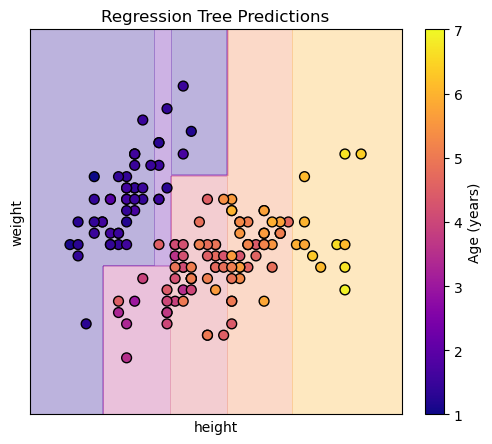

In [66]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_decision_boundaries(ax, regressior, X, y, "Regression Tree Predictions")
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', edgecolor='k', s=50, vmin=1, vmax=7)
fig.colorbar(scatter, label='Age (years)')


Each region (leaf) of the tree will predict the mean age of the training samples that fall into that region.
Visualizing this in 3d shows us steps, because the regression tree creates a **piecewise constant** approximation of the target variable (age) over the feature space (height and weight).

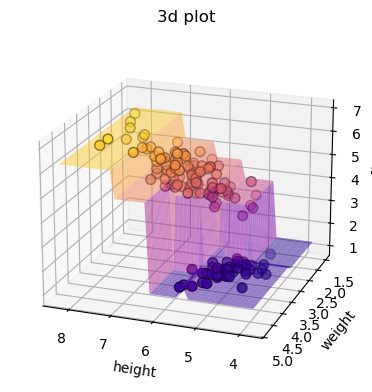

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121, projection='3d')
plot_decision_boundaries_3d(ax, regressior, X, y, "3d plot")
ax.view_init(elev=20, azim=110)

The same consideration regarding overfitting applies here as in classification.